# ***תרגיל 5 של הפרוייקט***

**Load Data and Basic Setup**

In [10]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("/content/train-filtered_question_level.csv")

# Remove duplicate questions
df = df.drop_duplicates(subset=["question"], keep="first")

# Extract text and difficulty levels
texts = df["question"].astype(str).tolist()
levels = df["level"].tolist()


**Balancing Dataset (Undersampling to Minority Class)**

In [11]:
# import pandas as pd

# # 1. נגדיר את גודל היעד לפי המחלקה הקטנה ביותר (Hard)
# target_size = 15657

# # 2. נבצע דגימה מכל מחלקה בנפרד
# df_hard = df[df['level'] == 'hard']
# # כאן אנחנו לא עושים sample כי זה כבר הגודל שאנחנו רוצים

# df_medium_downsampled = df[df['level'] == 'medium'].sample(n=target_size, random_state=42)
# df_easy_downsampled = df[df['level'] == 'easy'].sample(n=target_size, random_state=42)

# # 3. נחבר את שלושתן יחד
# df_balanced = pd.concat([df_hard, df_medium_downsampled, df_easy_downsampled])

# # 4. נערבב את הדאטה (חשוב מאוד!)
# df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# # בדיקת תוצאה
# print("התפלגות חדשה:")
# print(df_balanced['level'].value_counts())

In [12]:
import pandas as pd

# 1. הגדרת גודל המדגם לכל קטגוריה (היפר-פרמטר של שלב הניסויים)
# התחלה עם 1000 מכל אחת עוזרת לבדיקה מהירה ("מתחילים בקטן" לפי ההוראות)
target_size = 7000

# 2. דגימה מאוזנת מכל הקטגוריות בבת אחת
# groupby מבטיח שנתייחס לכל רמת קושי בנפרד
df_balanced = df.groupby('level').apply(lambda x: x.sample(n=target_size, random_state=42)).reset_index(drop=True)

# 3. ערבוב הדאטה (Shuffle) - קריטי בלמידה עמוקה!
# כדי שה-Batch לא יכיל רק מחלקה אחת בזמן האימון, מה שיהרוס את הלמידה
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# בדיקת התפלגות כפי שנדרש בשלב ה-EDA ובניתוח הדאטה
print("התפלגות חדשה ומאוזנת:")
print(df_balanced['level'].value_counts())

התפלגות חדשה ומאוזנת:
level
easy      7000
medium    7000
hard      7000
Name: count, dtype: int64


/tmp/ipython-input-4281571597.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('level').apply(lambda x: x.sample(n=target_size, random_state=42)).reset_index(drop=True)


In [13]:
import numpy as np

# זיהוי אוטומטי של עמודת הטקסט (מחפש עמודה שהיא אובייקט/סטרינג ואינה 'level')
text_col = [c for c in df_balanced.columns if df_balanced[c].dtype == 'object' and c != 'level'][0]
print(f"מנתח נתונים לפי עמודה: {text_col}")

# חישוב מדדים סטטיסטיים
df_balanced['word_count'] = df_balanced[text_col].apply(lambda x: len(str(x).split()))
df_balanced['avg_word_length'] = df_balanced[text_col].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0)

# 1. הדפסת דוגמאות אמיתיות לדו"ח
print("\n" + "="*50)
print("🔹 דוגמאות מייצגות לכל רמה (לצורך ניתוח איכותני)")
print("="*50)
for level in sorted(df_balanced['level'].unique()):
    print(f"\n📌 רמה: {level}")
    samples = df_balanced[df_balanced['level'] == level][text_col].head(3).values
    for i, s in enumerate(samples, 1):
        print(f"  {i}. {s[:150]}...") # מדפיס רק את תחילת המשפט

# 2. טבלת השוואה סטטיסטית
print("\n" + "="*50)
print("📊 מדדים לשוניים ממוצעים לכל רמה")
print("="*50)
comparison = df_balanced.groupby('level').agg({
    'word_count': 'mean',
    'avg_word_length': 'mean'
}).rename(columns={'word_count': 'ממוצע מילים למשפט', 'avg_word_length': 'אורך מילה ממוצע'}).round(2)

print(comparison)

מנתח נתונים לפי עמודה: question

🔹 דוגמאות מייצגות לכל רמה (לצורך ניתוח איכותני)

📌 רמה: easy
  1. This is a list of NFL Draft selections by the Indianapolis Colts, the first draft that the current incarnation of the Colts franchise participated in ...
  2. In late December 1980, there were a series of reported sightings of unexplained lights near Rendlesham Forest, Suffolk, England, which have become lin...
  3. What country was the businessman who founded an American hip hop apparel company? ...

📌 רמה: hard
  1. What party is the governor who Karen Jackson served as Deputy Secretary of Technology under?...
  2. Where both Games Magazine and The General published by Games Publications?...
  3. The Devonwood Bike Trail serves the shopping mall in Windsor, Ontario, Canada and which airport?...

📌 רמה: medium
  1. The Prince of the Pagodas's music was commissioned from a composer who passed away in which year ?...
  2. when was thevAmerican composer of music for films, who produced Lost

# **שלב 1**

# **א**

**Choosing Maximum Sequence Length (Documentation)**

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

# 1. הגדרת פרמטרים
VOCAB_SIZE = 20000

# 2. אתחול הטוקנייזר (יצירת האובייקט שהיה חסר)
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")

# 3. חילוץ הטקסטים מהדאטה המאוזן (ודא ששם העמודה נכון, נניח 'text')
texts = df_balanced['question'].astype(str).tolist()

# 4. התאמת הטוקנייזר על הטקסטים (שלב קריטי!)
tokenizer.fit_on_texts(texts)

# 5. המרה לרצפים של מספרים
sequences = tokenizer.texts_to_sequences(texts)

# עכשיו הסטטיסטיקות שלך יעבדו:
sequence_lengths = [len(seq) for seq in sequences]
avg_len = np.mean(sequence_lengths)
percentile_95 = np.percentile(sequence_lengths, 95)

print("Average sequence length:", round(avg_len, 2))
print("95th percentile length:", percentile_95)
print("Vocabulary size (actual):", len(tokenizer.word_index))

Average sequence length: 19.24
95th percentile length: 44.0
Vocabulary size (actual): 36542


**Padding and Truncation**

In [15]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. הגדרת המילון (למקרה שלא הוגדר בתא הזה)
label_dict = {'easy': 0, 'medium': 1, 'hard': 2}

# 2. קביעת אורך הרצף
MAX_SEQUENCE_LENGTH = int(percentile_95)

# 3. יצירת X (Padding)
X = pad_sequences(
    sequences,
    maxlen=MAX_SEQUENCE_LENGTH,
    padding="post",
    truncating="post"
)

# 4. יצירת y (הפיכת הקטגוריות למטריצה של 0 ו-1)
y_integers = df_balanced['level'].map(label_dict).values
y = to_categorical(y_integers, num_classes=3)

print(f"Data is ready! X shape: {X.shape}, y shape: {y.shape}")

Data is ready! X shape: (21000, 44), y shape: (21000, 3)


# **ב**

**ניסוי 1**


**Embedding Layer מאומן מאפס**

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# --- 1. הגדרת ארכיטקטורת המודל (בדיוק כמו ה-Keras שהיה לנו) ---
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        # ב-LSTM אנחנו לוקחים את ה-hidden state האחרון
        _, (hidden, _) = self.lstm(embedded)
        out = self.dropout(hidden[-1])
        return self.fc(out)

from sklearn.model_selection import train_test_split
import numpy as np

# 1. שלב ראשון: חלוקה ל-70% אימון ו-30% זמני (שיתחלק בהמשך לולידציה וטסט)
# הפרמטר stratify=y_integers מבטיח שהיחס בין הקטגוריות יישמר בדיוק כמו בדאטה המקורי
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_integers, test_size=0.30, random_state=42, stratify=y_integers
)

# 2. שלב שני: חלוקת ה-30% הנותרים חצי-חצי (15% ולידציה ו-15% טסט)
# גם כאן משתמשים ב-stratify כדי לשמור על האיזון בתוך הסטים הקטנים
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# 3. הפיכה ל-PyTorch Tensors
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.long), torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(y_test, dtype=torch.long))

# 4. יצירת ה-DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# בדיקה ויזואלית שהחלוקה אכן שווה (יופיע בדו"ח שלכם תחת "תיאור הדאטה")
def print_distribution(labels, name):
    counts = np.bincount(labels)
    ratios = counts / len(labels)
    print(f"{name} set: Easy: {ratios[0]:.1%}, Medium: {ratios[1]:.1%}, Hard: {ratios[2]:.1%}")

print_distribution(y_train, "Train")
print_distribution(y_val, "Validation")
print_distribution(y_test, "Test")

# --- 3. יצירת המודל, האופטימייזר וה-Loss ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMClassifier(VOCAB_SIZE, 100, 64, 3).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# --- 4. לולאת האימון (עם ה-print שביקשת) ---
epochs = 10
print("Starting training (PyTorch version)...")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # חישוב דיוק על ה-Validation (בדיוק כמו ב-Keras)
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    print(f"Epoch {epoch+1}/{epochs} "
          f"━━━━━━━━━━━━━━━━━━━━ "
          f"loss: {running_loss/len(train_loader):.4f} - "
          f"acc: {100.*correct/total:.2f}% - "
          f"val_acc: {100.*val_correct/val_total:.2f}%")

Train set: Easy: 33.3%, Medium: 33.3%, Hard: 33.3%
Validation set: Easy: 33.3%, Medium: 33.3%, Hard: 33.3%
Test set: Easy: 33.3%, Medium: 33.3%, Hard: 33.3%
Starting training (PyTorch version)...
Epoch 1/10 ━━━━━━━━━━━━━━━━━━━━ loss: 1.0013 - acc: 43.87% - val_acc: 46.60%
Epoch 2/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.9614 - acc: 46.68% - val_acc: 48.22%
Epoch 3/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.9100 - acc: 50.48% - val_acc: 51.40%
Epoch 4/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.8511 - acc: 53.91% - val_acc: 51.87%
Epoch 5/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.7880 - acc: 58.05% - val_acc: 50.29%
Epoch 6/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.7204 - acc: 62.41% - val_acc: 51.11%
Epoch 7/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.6504 - acc: 66.56% - val_acc: 50.13%
Epoch 8/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.5856 - acc: 70.89% - val_acc: 48.92%
Epoch 9/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.5245 - acc: 74.88% - val_acc: 48.51%
Epoch 10/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.4702 - acc: 78.56% - val_acc: 48.06%


**dounload GloVe**

In [9]:
# הורדת קובץ ה-GloVe (זה עשוי לקחת דקה-שתיים)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2026-01-06 10:58:54--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2026-01-06 10:58:55--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2026-01-06 10:58:56--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

**Creating the Embedding Matrix from GloVe**

In [17]:
import numpy as np
import torch

def create_embedding_matrix(word_index, vocab_size, embedding_dim=100):
    # 1. טעינת הוקטורים מהקובץ
    embeddings_index = {}
    with open('glove.6B.100d.txt', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    # 2. בניית המטריצה עבור ה-Vocab שלנו
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i < vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
            else:
                # מילים שלא נמצאו יקבלו וקטור רנדומלי (או אפסים)
                embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return torch.tensor(embedding_matrix, dtype=torch.float32)

# יצירת המטריצה
embedding_weights = create_embedding_matrix(tokenizer.word_index, VOCAB_SIZE)

**Building the model in PyTorch with Frozen/Fine-tuned support**

In [18]:
import torch.nn as nn

class GloVeLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, weights, freeze=True):
        super(GloVeLSTMModel, self).__init__()

        # טעינת המשקולות של GloVe
        # ה-parameter 'freeze' קובע אם המודל יעדכן את הוקטורים (Fine-tune) או לא (Frozen)
        self.embedding = nn.Embedding.from_pretrained(weights, freeze=freeze)

        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        out = self.dropout(hidden[-1])
        return self.fc(out)

**The Frozen model**

In [19]:
model_frozen = GloVeLSTMModel(VOCAB_SIZE, 100, 64, 3, embedding_weights, freeze=True).to(device)
# כאן תבוא לולאת האימון (אותה לולאה שכתבנו קודם)
print("Training Frozen GloVe Model...")
# train_model(model_frozen, train_loader)

Training Frozen GloVe Model...


**Fine-tuned**

In [20]:
# model_finetune = GloVeLSTMModel(VOCAB_SIZE, 100, 64, 3, embedding_weights, freeze=False).to(device)
# print("Training Fine-tuned GloVe Model...")
# # train_model(model_finetune, train_loader)

# **שלב 2**

**Basic Settings**

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# =========================
# סעיף א: ארכיטקטורת המודל
# =========================
class FlexibleModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers,
                 model_type='LSTM', bidirectional=False, dropout_p=0.0, embedding_matrix=None):
        super(FlexibleModel, self).__init__()

        # =========================
        # שינוי #1: Dropout כפרמטר אחד שנשלוט בו
        # =========================
        self.dropout = nn.Dropout(dropout_p)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
            self.embedding.weight.requires_grad = False  # הקפאת Embeddings

        # =========================
        # שינוי #2: dropout פנימי של RNN/LSTM (פעיל רק אם n_layers > 1)
        # ב-PyTorch dropout פנימי עובד בין שכבות, ולכן שכבה אחת => 0.0
        # =========================
        rnn_dropout = dropout_p if n_layers > 1 else 0.0

        if model_type == 'RNN':
            self.rnn = nn.RNN(
                embed_dim, hidden_dim, n_layers,
                batch_first=True,
                bidirectional=bidirectional,
                dropout=rnn_dropout
            )
        else:
            self.rnn = nn.LSTM(
                embed_dim, hidden_dim, n_layers,
                batch_first=True,
                bidirectional=bidirectional,
                dropout=rnn_dropout
            )

        num_directions = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_dim * num_directions, output_dim)

        # =========================
        # שינוי #3: הסרה של הגדרת self.dropout פעם שנייה
        # (אצלך הייתה דריסה + שימוש במשתנה dropout שלא קיים)
        # =========================

    def forward(self, text):
        # =========================
        # שינוי #4: dropout חיצוני על embeddings (נשלט ע"י dropout_p)
        # dropout_p=0.0 => בפועל אין dropout
        # =========================
        embedded = self.dropout(self.embedding(text))

        output, hidden = self.rnn(embedded)

        # LSTM מחזיר (h_n, c_n), RNN מחזיר h_n
        if isinstance(hidden, tuple):
            hidden = hidden[0]

        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            hidden = hidden[-1, :, :]

        return self.fc(hidden)


# ==========================================
# סעיף ב: תהליך האימון - שמירת היסטוריה מלאה
# ==========================================
def run_experiment(model, train_loader, val_loader, epochs=5, lr=0.001):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        # אימון
        model.train()
        total_train_loss = 0.0

        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # ולידציה
        model.eval()
        total_val_loss = 0.0
        correct = 0

        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)

                outputs = model(texts)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                correct += (outputs.argmax(1) == labels).sum().item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        acc = correct / len(val_loader.dataset)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {acc:.4f}")

    return history


# ======================
# סעיף ג: הערכת ביצועים
# ======================
def print_evaluation_section_c(model, loader):
    print("\n" + "=" * 30)
    print("סעיף ג: הערכת ביצועים")
    print("=" * 30)

    model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for texts, labels in loader:
            texts = texts.to(device)
            outputs = model(texts)

            preds = outputs.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    print(classification_report(all_labels, all_preds, target_names=['Easy', 'Medium', 'Hard']))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=['Easy', 'Medium', 'Hard'],
        yticklabels=['Easy', 'Medium', 'Hard']
    )
    plt.title("Confusion Matrix")
    plt.show()


# ======================
# גרפים: Loss ו-Accuracy
# ======================
def plot_training_history(history, model_name="Model"):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss (Error) Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [43]:
def decode_text(text_tensor, tokenizer):
    # שימוש במיפוי של Keras (index_word)
    # i.item() > 0 כי 0 הוא בדרך כלל ה-Padding
    index_to_word = tokenizer.index_word
    words = [index_to_word.get(i.item(), "") for i in text_tensor if i.item() > 0]
    return " ".join(words).strip()

def print_misclassifications(model, dataloader, device, tokenizer, label_map, target_true='Medium', target_pred='Hard', num_examples=5):
    model.eval()
    results = []

    # מיפוי שמות לקטגוריות (למשל 'Medium' -> 1)
    inv_label_map = {v: k for k, v in label_map.items()}
    true_idx = inv_label_map[target_true]
    pred_idx = inv_label_map[target_pred]

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            preds = outputs.argmax(1)

            for i in range(len(labels)):
                if labels[i].item() == true_idx and preds[i].item() == pred_idx:
                    # שימוש ב-decode_text החדש שמתאים לטוקנייזר שלך
                    original_text = decode_text(texts[i], tokenizer)
                    results.append(original_text)

                if len(results) >= num_examples:
                    break
            if len(results) >= num_examples:
                break

    print(f"\n--- דוגמאות של {target_true} שסווגו בטעות כ-{target_pred} ---")
    if not results:
        print("לא נמצאו דוגמאות כאלו בניסוי הנוכחי.")
    else:
        for j, text in enumerate(results):
            print(f"{j+1}) {text}\n")

**RNN - Regular embedding**

/tmp/ipython-input-3965154871.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


--- מריץ ניסוי: RNN | Bi=False | Dropout=0.2 | LR=0.0005 ---
Epoch 1/30 | Train Loss: 1.0014 | Val Loss: 0.9769 | Val Acc: 0.4594
Epoch 2/30 | Train Loss: 0.9828 | Val Loss: 0.9818 | Val Acc: 0.4483
Epoch 3/30 | Train Loss: 0.9794 | Val Loss: 0.9674 | Val Acc: 0.4597
Epoch 4/30 | Train Loss: 0.9734 | Val Loss: 0.9846 | Val Acc: 0.4635
Epoch 5/30 | Train Loss: 0.9661 | Val Loss: 0.9540 | Val Acc: 0.4670
Epoch 6/30 | Train Loss: 0.9611 | Val Loss: 0.9531 | Val Acc: 0.4835
Epoch 7/30 | Train Loss: 0.9580 | Val Loss: 0.9445 | Val Acc: 0.4810
Epoch 8/30 | Train Loss: 0.9538 | Val Loss: 0.9632 | Val Acc: 0.4695
Epoch 9/30 | Train Loss: 0.9503 | Val Loss: 0.9513 | Val Acc: 0.4733
Epoch 10/30 | Train Loss: 0.9450 | Val Loss: 0.9506 | Val Acc: 0.4965
Epoch 11/30 | Train Loss: 0.9445 | Val Loss: 0.9367 | Val Acc: 0.4863
Epoch 12/30 | Train Loss: 0.9366 | Val Loss: 0.9427 | Val Acc: 0.4778
Epoch 13/30 | Train Loss: 0.9329 | Val Loss: 0.9361 | Val Acc: 0.4971
Epoch 14/30 | Train Loss: 0.9337 | Val

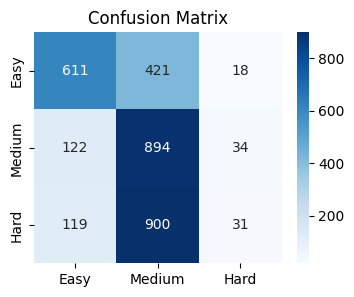

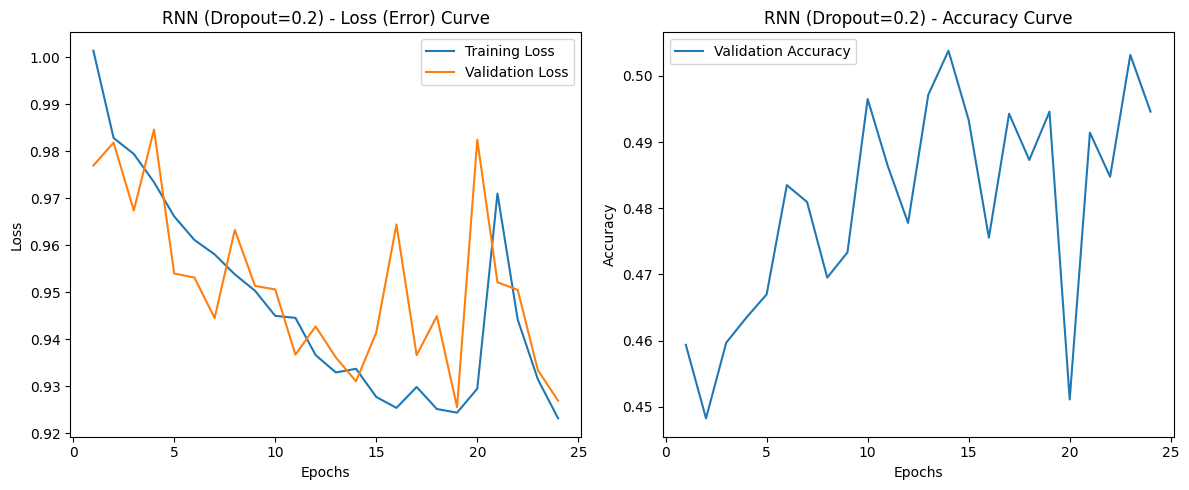

In [47]:
# ==========================================
# ניסוי מספר X: הגדרת פרמטרים (כאן את שולטת בשינויים)
# ==========================================
MODEL_TYPE = 'RNN'          # אפשרויות: 'RNN', 'LSTM'
IS_BIDIRECTIONAL = False      # אפשרויות: True, False
DROPOUT_P = 0.2              # ערך בין 0.0 ל-0.5
LEARNING_RATE = 0.0005       # קצב למידה
EPOCHS = 30                  # מספר איטרציות
N_LAYERS = 1                 # מספר שכבות (אם > 1 ה-dropout הפנימי פועל)

# א. יצירת המודל עם הפרמטרים שנבחרו
model_experiment = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=128,
    output_dim=3,
    n_layers=N_LAYERS,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    embedding_matrix=EMBED_MAT, # וודאי ש-EMBED_MAT מוגדר בתיבה קודמת
    dropout_p=DROPOUT_P
)

# ב. הרצת האימון
print(f"--- מריץ ניסוי: {MODEL_TYPE} | Bi={IS_BIDIRECTIONAL} | Dropout={DROPOUT_P} | LR={LEARNING_RATE} ---")
history = run_experiment(
    model_experiment,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE
)

# ג. הצגת תוצאות
print_evaluation_section_c(model_experiment, test_loader)
plot_training_history(history, model_name=f"{MODEL_TYPE} (Dropout={DROPOUT_P})")

In [49]:
# הגדרת המפה לפי הסדר של המחלקות אצלך
label_map = {0: 'Easy', 1: 'Medium', 2: 'Hard'}

# קריאה לפונקציה
print_misclassifications(
    model_experiment,
    test_loader,
    device,
    tokenizer,   # הטוקנייזר שהגדרת קודם
    label_map,
    target_true='Medium',
    target_pred='Hard',
    num_examples=5
)


--- דוגמאות של Medium שסווגו בטעות כ-Hard ---
1) david m <OOV> worked at a digital magazine which is headquartered in san francisco and was first published in 1985 by who

2) what is the name of this english psychedelic folk acid folk trio who formed in 1966 and is comprised of the story

3) what movie was directed by tom vaughan and stars an actress that also starred in the mask and my best <OOV> wedding

4) <OOV> <OOV> <OOV> bob dylan <OOV> homage with which song that was for the soundtrack of the 1973 film pat garrett and billy the kid

5) in what year did the english actor known for his big acting style that appear in a film with denzel washington



**RNN - GloVe frozen**

/tmp/ipython-input-3965154871.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


--- מריץ ניסוי: RNN | GloVe Frozen | Dropout=0.3 | LR=0.0005 ---
Epoch 1/30 | Train Loss: 1.0010 | Val Loss: 0.9775 | Val Acc: 0.4584
Epoch 2/30 | Train Loss: 0.9912 | Val Loss: 0.9955 | Val Acc: 0.4511
Epoch 3/30 | Train Loss: 0.9839 | Val Loss: 0.9662 | Val Acc: 0.4590
Epoch 4/30 | Train Loss: 0.9808 | Val Loss: 0.9742 | Val Acc: 0.4610
Epoch 5/30 | Train Loss: 0.9754 | Val Loss: 1.0313 | Val Acc: 0.4365
Epoch 6/30 | Train Loss: 0.9702 | Val Loss: 0.9662 | Val Acc: 0.4594
Epoch 7/30 | Train Loss: 0.9645 | Val Loss: 0.9529 | Val Acc: 0.4768
Epoch 8/30 | Train Loss: 0.9612 | Val Loss: 0.9516 | Val Acc: 0.4835
Epoch 9/30 | Train Loss: 0.9524 | Val Loss: 0.9406 | Val Acc: 0.4946
Epoch 10/30 | Train Loss: 0.9494 | Val Loss: 0.9530 | Val Acc: 0.4702
Epoch 11/30 | Train Loss: 0.9475 | Val Loss: 0.9437 | Val Acc: 0.4854
Epoch 12/30 | Train Loss: 0.9437 | Val Loss: 0.9358 | Val Acc: 0.4883
Epoch 13/30 | Train Loss: 0.9414 | Val Loss: 0.9371 | Val Acc: 0.4990
Epoch 14/30 | Train Loss: 0.9389 |

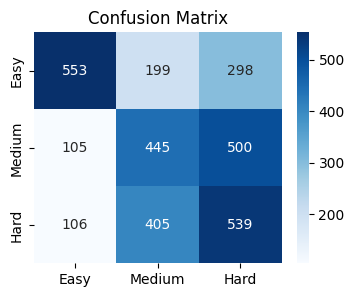


--- דוגמאות של Medium שסווגו בטעות כ-Hard ---
1) who directed james cromwell when he acted in his 2006 british fictional drama

2) erik koch formerly competed for the mma promotion founded in what year

3) which member of the weather underground who was born in may 1943 was able to escape the greenwich village <OOV> explosion

4) who is the coach for nd črnuče in 1994 who was born 27 may 1947

5) are both david byrne and emily haines a songwriter



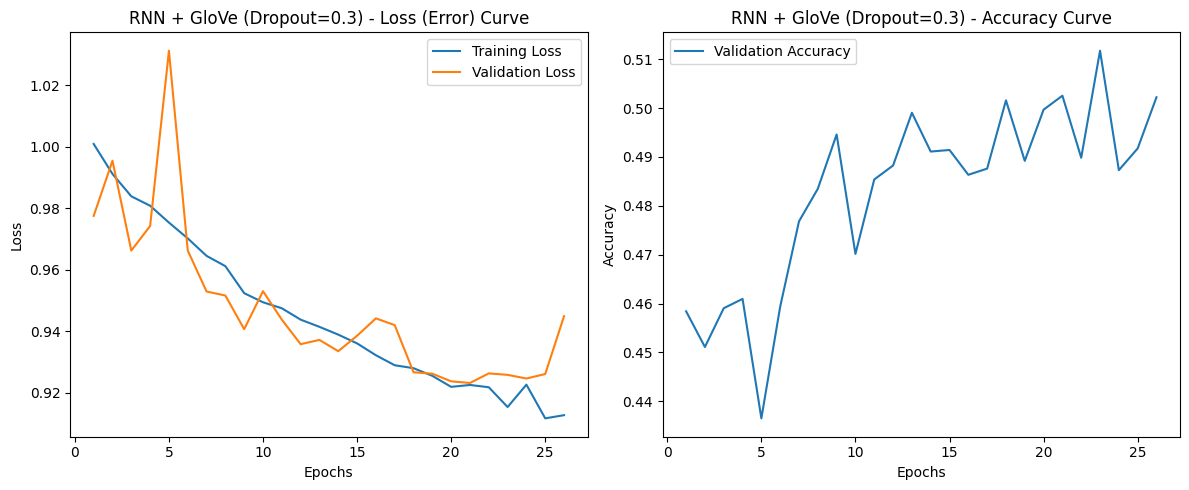

In [52]:
# ==========================================
# ניסוי 2: RNN + GloVe (Frozen) - שליטה בפרמטרים
# ==========================================

# 1. הגדרת פרמטרים (כאן את משנה את הערכים)
MODEL_TYPE = 'RNN'           # אפשרויות: 'RNN', 'LSTM'
IS_BIDIRECTIONAL = False     # אפשרויות: True, False
DROPOUT_P = 0.3              # הוספנו 0.2 כפי שהמלצנו בתוכנית הפעולה
LEARNING_RATE = 0.0005       # קצב למידה נמוך ליציבות
EPOCHS = 30                  # מספר איטרציות מקסימלי (ייעצר ע"י Early Stopping)
EMBED_MAT = embedding_weights # וודאי ש-embedding_weights הוגדר קודם

# א. יצירת המודל (FlexibleModel)
model_1 = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=128,
    output_dim=3,
    n_layers=1,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    embedding_matrix=EMBED_MAT, # כאן נכנס ה-GloVe
    dropout_p=DROPOUT_P
)

# ב. הרצת האימון (משתמש בפרמטרים שהגדרנו למעלה)
print(f"--- מריץ ניסוי: {MODEL_TYPE} | GloVe Frozen | Dropout={DROPOUT_P} | LR={LEARNING_RATE} ---")

history_1 = run_experiment(
    model_1,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
)

# ג. הערכת ביצועים והצגת תוצאות
print_evaluation_section_c(model_1, test_loader)

# דוגמאות לטעויות (לראות אם ה-GloVe עזר בשמות פרטיים)
label_map = {0: 'Easy', 1: 'Medium', 2: 'Hard'}
print_misclassifications(model_1, test_loader, device, tokenizer, label_map, target_true='Medium', target_pred='Hard')

# ה. גרפים
plot_training_history(history_1, model_name=f"{MODEL_TYPE} + GloVe (Dropout={DROPOUT_P})")

**LSTM - Regular embedding**

מתחיל ניסוי: LSTM, Bidirectional=False, Dropout_p=0.0
Epoch 1/5 | Train Loss: 0.9943 | Val Loss: 0.9731 | Val Acc: 0.4575
Epoch 2/5 | Train Loss: 0.9571 | Val Loss: 0.9441 | Val Acc: 0.4800
Epoch 3/5 | Train Loss: 0.9105 | Val Loss: 0.9202 | Val Acc: 0.5022
Epoch 4/5 | Train Loss: 0.8567 | Val Loss: 0.9335 | Val Acc: 0.5035
Epoch 5/5 | Train Loss: 0.7927 | Val Loss: 0.9250 | Val Acc: 0.4968

סעיף ג: הערכת ביצועים
              precision    recall  f1-score   support

        Easy       0.68      0.63      0.65      1050
      Medium       0.43      0.05      0.09      1050
        Hard       0.41      0.80      0.54      1050

    accuracy                           0.49      3150
   macro avg       0.50      0.49      0.43      3150
weighted avg       0.50      0.49      0.43      3150



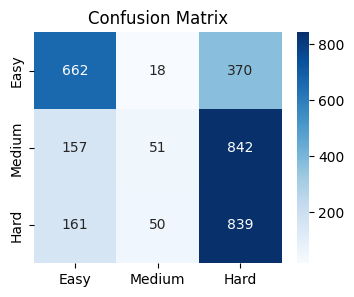

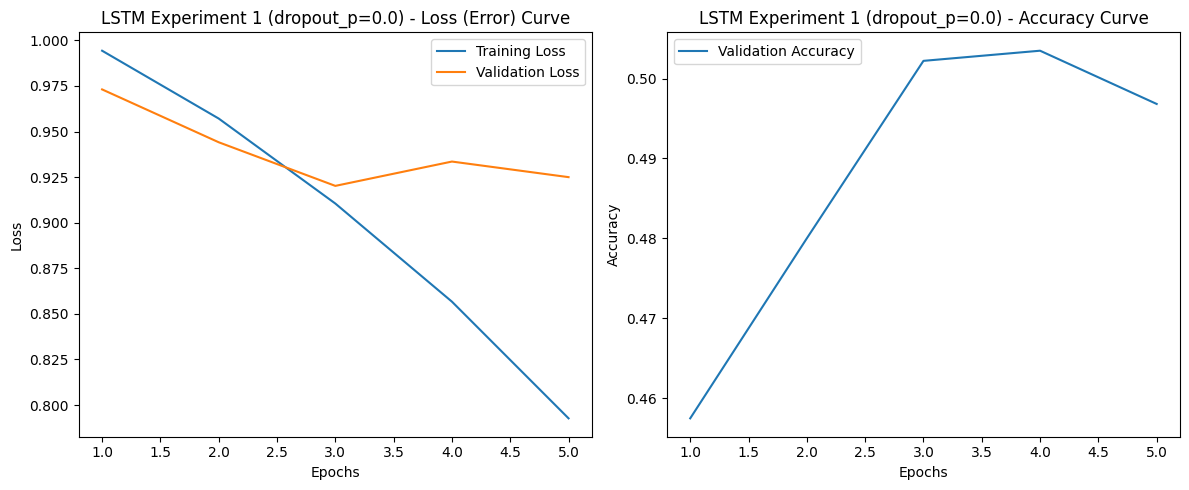

In [26]:

# ניסוי 3: LSTM + regular embedding

MODEL_TYPE = 'LSTM'
IS_BIDIRECTIONAL = False
EMBED_MAT = None

# =========================
# שינוי #5: הוספת DROPOUT_P כדי לשלוט בניסוי
# =========================
DROPOUT_P = 0.0  # <-- ניסוי ללא Dropout (לניסוי עם Dropout: 0.2 למשל)

# א. הגדרת המודל
model_1 = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=128,
    output_dim=3,
    n_layers=1,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    embedding_matrix=EMBED_MAT,
    dropout_p=DROPOUT_P  # <-- שינוי #6: זה הפרמטר שמכבה/מדליק בפועל
)

# ב. אימון המודל
print(f"מתחיל ניסוי: {MODEL_TYPE}, Bidirectional={IS_BIDIRECTIONAL}, Dropout_p={DROPOUT_P}")
history_1 = run_experiment(model_1, train_loader, val_loader, epochs=5)

# ג. הערכת ביצועים
print_evaluation_section_c(model_1, test_loader)

# הדפסת הגרף של סעיף ב.2
plot_training_history(history_1, model_name=f"{MODEL_TYPE} Experiment 1 (dropout_p={DROPOUT_P})")

**WITH DROPOUT**

מתחיל ניסוי: LSTM, Bidirectional=False, Dropout_p=0.2
Epoch 1/5 | Train Loss: 0.9989 | Val Loss: 0.9656 | Val Acc: 0.4632
Epoch 2/5 | Train Loss: 0.9694 | Val Loss: 0.9497 | Val Acc: 0.4727
Epoch 3/5 | Train Loss: 0.9345 | Val Loss: 0.9211 | Val Acc: 0.5022
Epoch 4/5 | Train Loss: 0.8810 | Val Loss: 0.8963 | Val Acc: 0.5222
Epoch 5/5 | Train Loss: 0.8334 | Val Loss: 0.9126 | Val Acc: 0.5025

סעיף ג: הערכת ביצועים
              precision    recall  f1-score   support

        Easy       0.70      0.63      0.66      1050
      Medium       0.42      0.82      0.55      1050
        Hard       0.35      0.04      0.07      1050

    accuracy                           0.50      3150
   macro avg       0.49      0.50      0.43      3150
weighted avg       0.49      0.50      0.43      3150



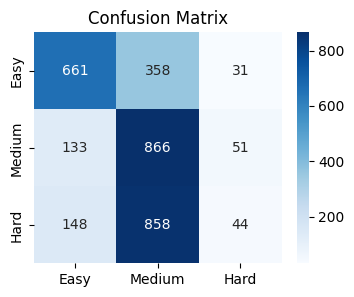

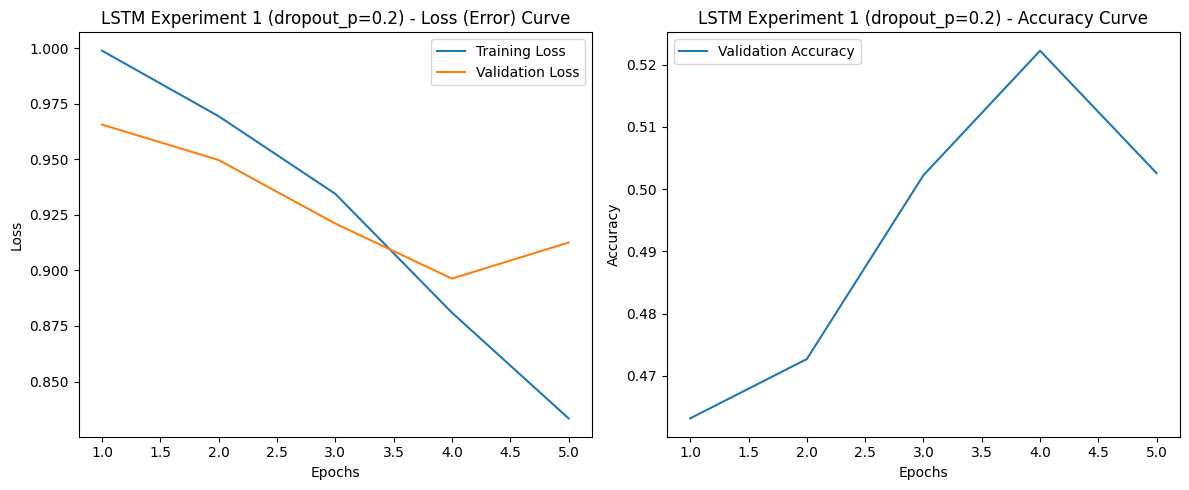

In [27]:

# ניסוי 3: LSTM + regular embedding WITH DROPOUT

MODEL_TYPE = 'LSTM'
IS_BIDIRECTIONAL = False
EMBED_MAT = None

# =========================
# שינוי #5: הוספת DROPOUT_P כדי לשלוט בניסוי
# =========================
DROPOUT_P = 0.2  # <-- ניסוי ללא Dropout (לניסוי עם Dropout: 0.2 למשל)

# א. הגדרת המודל
model_1 = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=128,
    output_dim=3,
    n_layers=1,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    embedding_matrix=EMBED_MAT,
    dropout_p=DROPOUT_P  # <-- שינוי #6: זה הפרמטר שמכבה/מדליק בפועל
)

# ב. אימון המודל
print(f"מתחיל ניסוי: {MODEL_TYPE}, Bidirectional={IS_BIDIRECTIONAL}, Dropout_p={DROPOUT_P}")
history_1 = run_experiment(model_1, train_loader, val_loader, epochs=5)

# ג. הערכת ביצועים
print_evaluation_section_c(model_1, test_loader)

# הדפסת הגרף של סעיף ב.2
plot_training_history(history_1, model_name=f"{MODEL_TYPE} Experiment 1 (dropout_p={DROPOUT_P})")

**LSTM - GloVe frozen**

/tmp/ipython-input-2152522295.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


מתחיל ניסוי: LSTM, Bidirectional=False, Dropout_p=0.0
Epoch 1/5 | Train Loss: 0.9831 | Val Loss: 0.9613 | Val Acc: 0.4629
Epoch 2/5 | Train Loss: 0.9646 | Val Loss: 0.9613 | Val Acc: 0.4775
Epoch 3/5 | Train Loss: 0.9463 | Val Loss: 0.9178 | Val Acc: 0.4997
Epoch 4/5 | Train Loss: 0.9197 | Val Loss: 0.8981 | Val Acc: 0.5124
Epoch 5/5 | Train Loss: 0.8952 | Val Loss: 0.9093 | Val Acc: 0.5206

סעיף ג: הערכת ביצועים
              precision    recall  f1-score   support

        Easy       0.70      0.63      0.67      1050
      Medium       0.44      0.80      0.57      1050
        Hard       0.45      0.12      0.19      1050

    accuracy                           0.52      3150
   macro avg       0.53      0.52      0.47      3150
weighted avg       0.53      0.52      0.47      3150



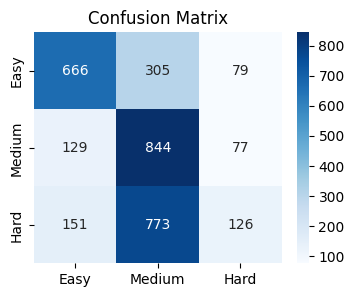

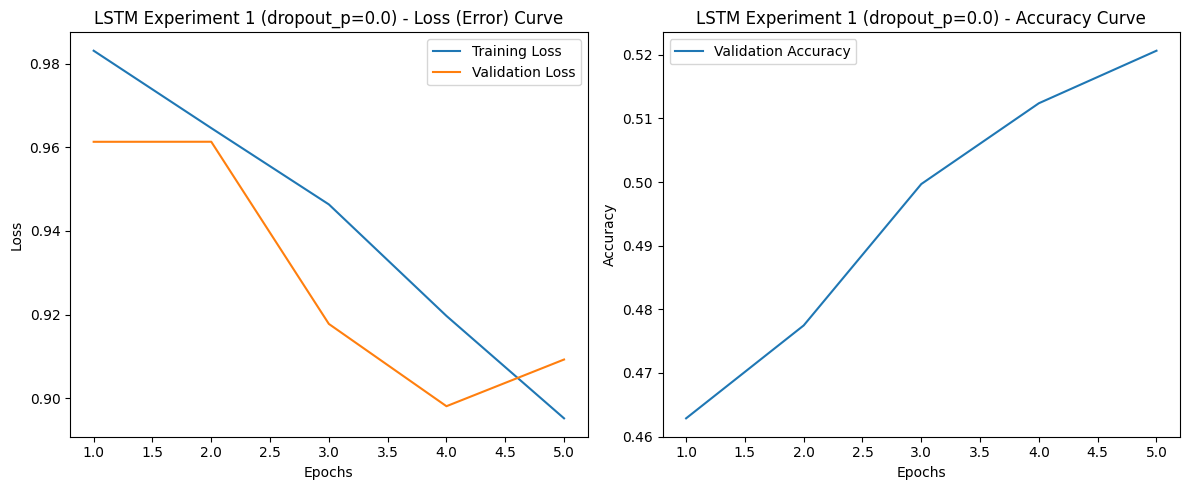

In [28]:
# ניסוי 4: LSTM + GloVe (Frozen)

MODEL_TYPE = 'LSTM'
IS_BIDIRECTIONAL = False
EMBED_MAT = embedding_weights

# =========================
# שינוי #5: הוספת DROPOUT_P כדי לשלוט בניסוי
# =========================
DROPOUT_P = 0.0  # <-- ניסוי ללא Dropout (לניסוי עם Dropout: 0.2 למשל)

# א. הגדרת המודל
model_1 = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=128,
    output_dim=3,
    n_layers=1,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    embedding_matrix=EMBED_MAT,
    dropout_p=DROPOUT_P  # <-- שינוי #6: זה הפרמטר שמכבה/מדליק בפועל
)

# ב. אימון המודל
print(f"מתחיל ניסוי: {MODEL_TYPE}, Bidirectional={IS_BIDIRECTIONAL}, Dropout_p={DROPOUT_P}")
history_1 = run_experiment(model_1, train_loader, val_loader, epochs=5)

# ג. הערכת ביצועים
print_evaluation_section_c(model_1, test_loader)

# הדפסת הגרף של סעיף ב.2
plot_training_history(history_1, model_name=f"{MODEL_TYPE} Experiment 1 (dropout_p={DROPOUT_P})")

**we add more epochs**

/tmp/ipython-input-2152522295.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


מתחיל ניסוי: LSTM, Bidirectional=False, Dropout_p=0.0
Epoch 1/10 | Train Loss: 0.9836 | Val Loss: 0.9676 | Val Acc: 0.4635
Epoch 2/10 | Train Loss: 0.9686 | Val Loss: 0.9451 | Val Acc: 0.4813
Epoch 3/10 | Train Loss: 0.9523 | Val Loss: 0.9597 | Val Acc: 0.4660
Epoch 4/10 | Train Loss: 0.9234 | Val Loss: 0.9144 | Val Acc: 0.5019
Epoch 5/10 | Train Loss: 0.9015 | Val Loss: 0.8933 | Val Acc: 0.5178
Epoch 6/10 | Train Loss: 0.8836 | Val Loss: 0.8907 | Val Acc: 0.5187
Epoch 7/10 | Train Loss: 0.8784 | Val Loss: 0.8944 | Val Acc: 0.5257
Epoch 8/10 | Train Loss: 0.8764 | Val Loss: 0.8939 | Val Acc: 0.5260
Epoch 9/10 | Train Loss: 0.8743 | Val Loss: 0.8976 | Val Acc: 0.5200
Epoch 10/10 | Train Loss: 0.8499 | Val Loss: 0.8924 | Val Acc: 0.5286

סעיף ג: הערכת ביצועים
              precision    recall  f1-score   support

        Easy       0.78      0.61      0.68      1050
      Medium       0.43      0.53      0.48      1050
        Hard       0.42      0.42      0.42      1050

    accuracy  

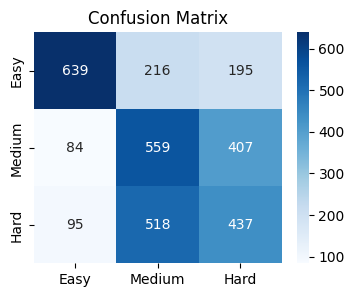

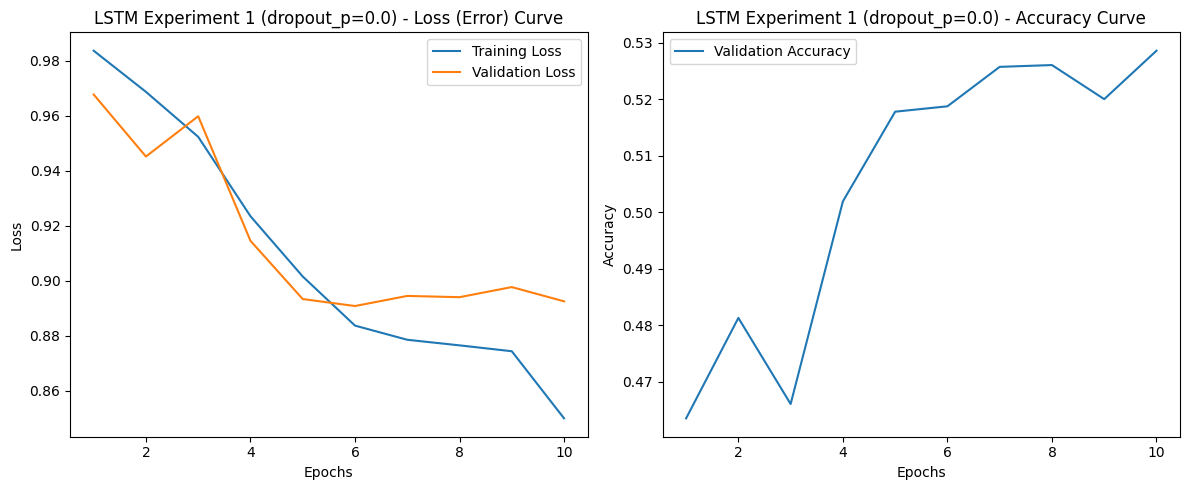

In [29]:
# ניסוי 4: LSTM + GloVe (Frozen)

MODEL_TYPE = 'LSTM'
IS_BIDIRECTIONAL = False
EMBED_MAT = embedding_weights

# =========================
# שינוי #5: הוספת DROPOUT_P כדי לשלוט בניסוי
# =========================
DROPOUT_P = 0.0  # <-- ניסוי ללא Dropout (לניסוי עם Dropout: 0.2 למשל)

# א. הגדרת המודל
model_1 = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=128,
    output_dim=3,
    n_layers=1,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    embedding_matrix=EMBED_MAT,
    dropout_p=DROPOUT_P  # <-- שינוי #6: זה הפרמטר שמכבה/מדליק בפועל
)

# ב. אימון המודל
print(f"מתחיל ניסוי: {MODEL_TYPE}, Bidirectional={IS_BIDIRECTIONAL}, Dropout_p={DROPOUT_P}")
history_1 = run_experiment(model_1, train_loader, val_loader, epochs=10)

# ג. הערכת ביצועים
print_evaluation_section_c(model_1, test_loader)

# הדפסת הגרף של סעיף ב.2
plot_training_history(history_1, model_name=f"{MODEL_TYPE} Experiment 1 (dropout_p={DROPOUT_P})")

**BiLSTM - regular embedding**

מתחיל ניסוי: LSTM, Bidirectional=True, Dropout_p=0.0
Epoch 1/5 | Train Loss: 0.9428 | Val Loss: 0.9192 | Val Acc: 0.4994
Epoch 2/5 | Train Loss: 0.8640 | Val Loss: 0.8862 | Val Acc: 0.5273
Epoch 3/5 | Train Loss: 0.7943 | Val Loss: 0.9192 | Val Acc: 0.5286
Epoch 4/5 | Train Loss: 0.6991 | Val Loss: 0.9815 | Val Acc: 0.5140
Epoch 5/5 | Train Loss: 0.5694 | Val Loss: 1.1079 | Val Acc: 0.5114

סעיף ג: הערכת ביצועים
              precision    recall  f1-score   support

        Easy       0.67      0.62      0.64      1050
      Medium       0.45      0.54      0.49      1050
        Hard       0.42      0.37      0.39      1050

    accuracy                           0.51      3150
   macro avg       0.51      0.51      0.51      3150
weighted avg       0.51      0.51      0.51      3150



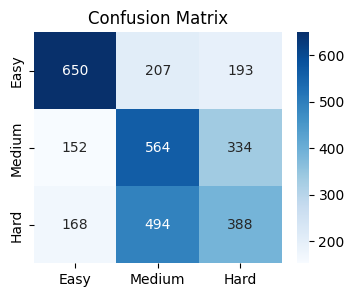

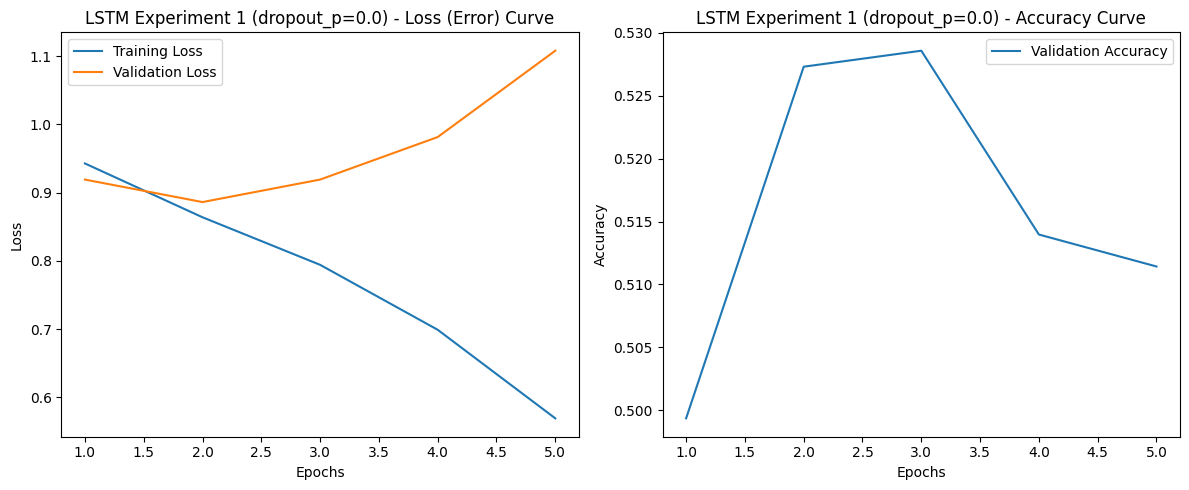

In [30]:
# --- ניסוי 5: BiLSTM + Regular Embedding  ---

MODEL_TYPE = 'LSTM'
IS_BIDIRECTIONAL = True
EMBED_MAT = None

# =========================
# שינוי #5: הוספת DROPOUT_P כדי לשלוט בניסוי
# =========================
DROPOUT_P = 0.0  # <-- ניסוי ללא Dropout (לניסוי עם Dropout: 0.2 למשל)

# א. הגדרת המודל
model_1 = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=128,
    output_dim=3,
    n_layers=1,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    embedding_matrix=EMBED_MAT,
    dropout_p=DROPOUT_P  # <-- שינוי #6: זה הפרמטר שמכבה/מדליק בפועל
)

# ב. אימון המודל
print(f"מתחיל ניסוי: {MODEL_TYPE}, Bidirectional={IS_BIDIRECTIONAL}, Dropout_p={DROPOUT_P}")
history_1 = run_experiment(model_1, train_loader, val_loader, epochs=5)

# ג. הערכת ביצועים
print_evaluation_section_c(model_1, test_loader)

# הדפסת הגרף של סעיף ב.2
plot_training_history(history_1, model_name=f"{MODEL_TYPE} Experiment 1 (dropout_p={DROPOUT_P})")

**WITH DROPOUT**

מתחיל ניסוי: LSTM, Bidirectional=True, Dropout_p=0.2
Epoch 1/5 | Train Loss: 0.9553 | Val Loss: 0.9012 | Val Acc: 0.5197
Epoch 2/5 | Train Loss: 0.8862 | Val Loss: 0.8879 | Val Acc: 0.5216
Epoch 3/5 | Train Loss: 0.8388 | Val Loss: 0.8834 | Val Acc: 0.5311
Epoch 4/5 | Train Loss: 0.7822 | Val Loss: 0.9291 | Val Acc: 0.5381
Epoch 5/5 | Train Loss: 0.7164 | Val Loss: 0.9548 | Val Acc: 0.5349

סעיף ג: הערכת ביצועים
              precision    recall  f1-score   support

        Easy       0.75      0.62      0.68      1050
      Medium       0.46      0.60      0.52      1050
        Hard       0.44      0.38      0.41      1050

    accuracy                           0.54      3150
   macro avg       0.55      0.54      0.54      3150
weighted avg       0.55      0.54      0.54      3150



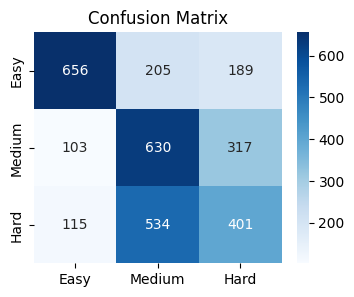

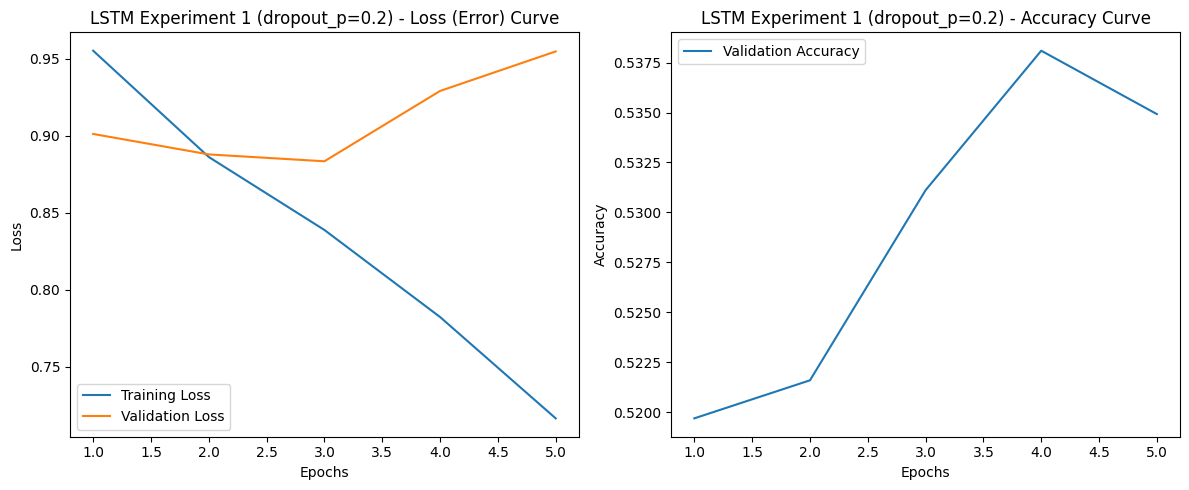

In [31]:
# --- ניסוי 5: BiLSTM + Regular Embedding WITH DROPOUT ---

MODEL_TYPE = 'LSTM'
IS_BIDIRECTIONAL = True
EMBED_MAT = None

# =========================
# שינוי #5: הוספת DROPOUT_P כדי לשלוט בניסוי
# =========================
DROPOUT_P = 0.2  # <-- ניסוי ללא Dropout (לניסוי עם Dropout: 0.2 למשל)

# א. הגדרת המודל
model_1 = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=128,
    output_dim=3,
    n_layers=1,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    embedding_matrix=EMBED_MAT,
    dropout_p=DROPOUT_P  # <-- שינוי #6: זה הפרמטר שמכבה/מדליק בפועל
)

# ב. אימון המודל
print(f"מתחיל ניסוי: {MODEL_TYPE}, Bidirectional={IS_BIDIRECTIONAL}, Dropout_p={DROPOUT_P}")
history_1 = run_experiment(model_1, train_loader, val_loader, epochs=5)

# ג. הערכת ביצועים
print_evaluation_section_c(model_1, test_loader)

# הדפסת הגרף של סעיף ב.2
plot_training_history(history_1, model_name=f"{MODEL_TYPE} Experiment 1 (dropout_p={DROPOUT_P})")

**Frozen BiLSTM - GloVe**

/tmp/ipython-input-2152522295.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


מתחיל ניסוי: LSTM, Bidirectional=True, Dropout_p=0.0
Epoch 1/5 | Train Loss: 0.9437 | Val Loss: 0.9177 | Val Acc: 0.5111
Epoch 2/5 | Train Loss: 0.8945 | Val Loss: 0.8832 | Val Acc: 0.5267
Epoch 3/5 | Train Loss: 0.8701 | Val Loss: 0.8772 | Val Acc: 0.5229
Epoch 4/5 | Train Loss: 0.8481 | Val Loss: 0.8798 | Val Acc: 0.5190
Epoch 5/5 | Train Loss: 0.8219 | Val Loss: 0.8759 | Val Acc: 0.5279

סעיף ג: הערכת ביצועים
              precision    recall  f1-score   support

        Easy       0.74      0.65      0.69      1050
      Medium       0.47      0.56      0.51      1050
        Hard       0.47      0.43      0.45      1050

    accuracy                           0.55      3150
   macro avg       0.56      0.55      0.55      3150
weighted avg       0.56      0.55      0.55      3150



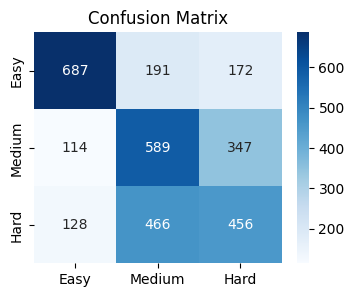

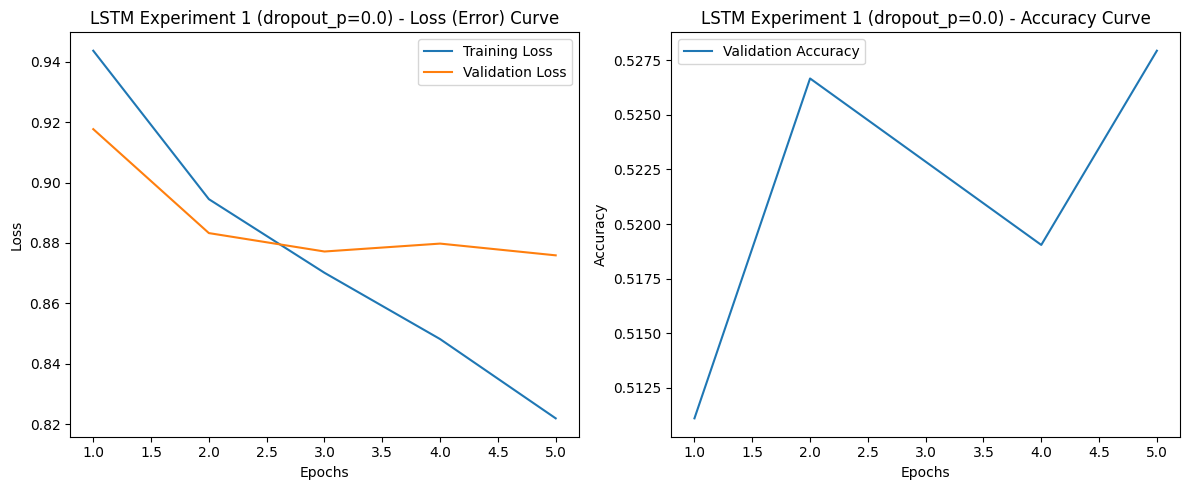

In [32]:
# --- ניסוי 6: BiLSTM + GloVe (Frozen) ---

MODEL_TYPE = 'LSTM'
IS_BIDIRECTIONAL = True
EMBED_MAT = embedding_weights

# =========================
# שינוי #5: הוספת DROPOUT_P כדי לשלוט בניסוי
# =========================
DROPOUT_P = 0.0  # <-- ניסוי ללא Dropout (לניסוי עם Dropout: 0.2 למשל)

# א. הגדרת המודל
model_1 = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=128,
    output_dim=3,
    n_layers=1,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    embedding_matrix=EMBED_MAT,
    dropout_p=DROPOUT_P  # <-- שינוי #6: זה הפרמטר שמכבה/מדליק בפועל
)

# ב. אימון המודל
print(f"מתחיל ניסוי: {MODEL_TYPE}, Bidirectional={IS_BIDIRECTIONAL}, Dropout_p={DROPOUT_P}")
history_1 = run_experiment(model_1, train_loader, val_loader, epochs=5)

# ג. הערכת ביצועים
print_evaluation_section_c(model_1, test_loader)

# הדפסת הגרף של סעיף ב.2
plot_training_history(history_1, model_name=f"{MODEL_TYPE} Experiment 1 (dropout_p={DROPOUT_P})")

**with dropout**

/tmp/ipython-input-2152522295.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


מתחיל ניסוי: LSTM, Bidirectional=True, Dropout_p=0.2
Epoch 1/5 | Train Loss: 0.9512 | Val Loss: 0.9046 | Val Acc: 0.5137
Epoch 2/5 | Train Loss: 0.9039 | Val Loss: 0.8915 | Val Acc: 0.5140
Epoch 3/5 | Train Loss: 0.8784 | Val Loss: 0.8780 | Val Acc: 0.5257
Epoch 4/5 | Train Loss: 0.8600 | Val Loss: 0.8691 | Val Acc: 0.5273
Epoch 5/5 | Train Loss: 0.8422 | Val Loss: 0.8696 | Val Acc: 0.5324

סעיף ג: הערכת ביצועים
              precision    recall  f1-score   support

        Easy       0.74      0.64      0.69      1050
      Medium       0.47      0.45      0.46      1050
        Hard       0.45      0.53      0.48      1050

    accuracy                           0.54      3150
   macro avg       0.55      0.54      0.54      3150
weighted avg       0.55      0.54      0.54      3150



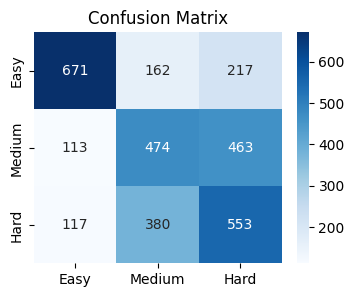

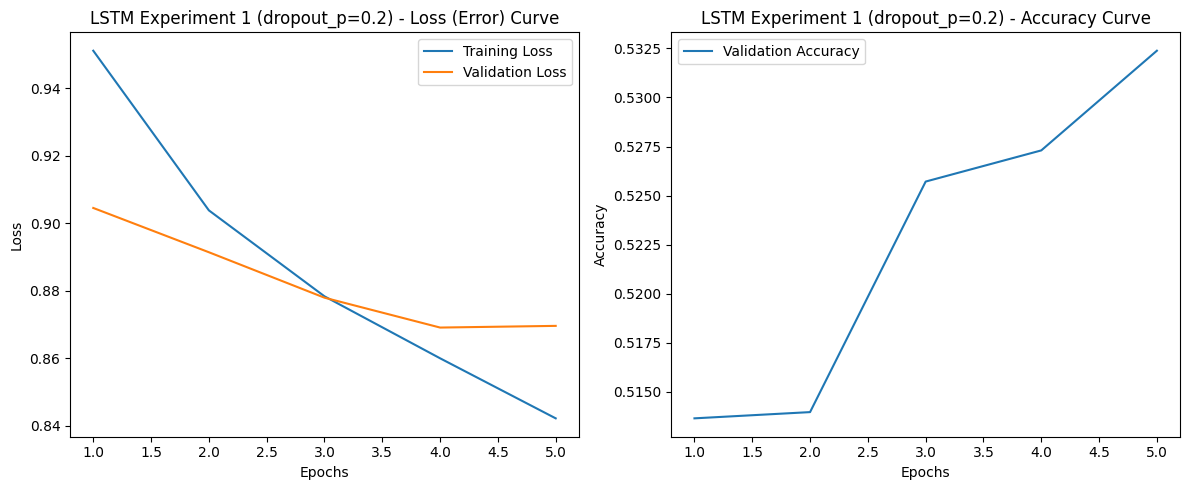

In [33]:
# --- ניסוי 6: BiLSTM + GloVe (Frozen) WITH DROPUT---

MODEL_TYPE = 'LSTM'
IS_BIDIRECTIONAL = True
EMBED_MAT = embedding_weights

# =========================
# שינוי #5: הוספת DROPOUT_P כדי לשלוט בניסוי
# =========================
DROPOUT_P = 0.2  # <-- ניסוי ללא Dropout (לניסוי עם Dropout: 0.2 למשל)

# א. הגדרת המודל
model_1 = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=128,
    output_dim=3,
    n_layers=1,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    embedding_matrix=EMBED_MAT,
    dropout_p=DROPOUT_P  # <-- שינוי #6: זה הפרמטר שמכבה/מדליק בפועל
)

# ב. אימון המודל
print(f"מתחיל ניסוי: {MODEL_TYPE}, Bidirectional={IS_BIDIRECTIONAL}, Dropout_p={DROPOUT_P}")
history_1 = run_experiment(model_1, train_loader, val_loader, epochs=5)

# ג. הערכת ביצועים
print_evaluation_section_c(model_1, test_loader)

# הדפסת הגרף של סעיף ב.2
plot_training_history(history_1, model_name=f"{MODEL_TYPE} Experiment 1 (dropout_p={DROPOUT_P})")